<a href="https://colab.research.google.com/github/muhammadanas25/Stock_trend_prediction/blob/main/Ensemble_model_(Adb_%2BRF).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Initial imports
import pandas as pd
!pip install path
from path import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline
# Initial imports
import pandas as pd
import numpy as np
from path import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

from sklearn.compose import make_column_selector as selector


In [ ]:
# Loading data
file_path = Path("RHT.V.csv")

df = pd.read_csv(file_path)
df.dropna(inplace=True)
df.tail()

,Date,Open,High,Low,Close,Volume,EF_1,EF_2,Oil FutureTrend,Gold FutureTrend,Trend,Twitter Sentiments,FutureTrend
736,23/06/2021,0.440,0.455,0.440,0.440,165500,0.000000,0.000000,Negative,Positive,Neutral,0,Negative
737,24/06/2021,0.440,0.490,0.440,0.455,502500,0.300000,3.409094,Negative,Negative,Positive,0,Positive
738,25/06/2021,0.460,0.465,0.450,0.450,207400,0.000000,-2.173917,Positive,Negative,Negative,0,Neutral
739,28/06/2021,0.465,0.470,0.450,0.450,224400,0.000000,-3.225810,Negative,Positive,Negative,0,Negative
740,29/06/2021,0.455,0.470,0.455,0.465,79200,0.666667,2.197800,Negative,Negative,Positive,0,Negative


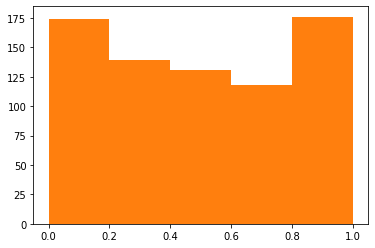

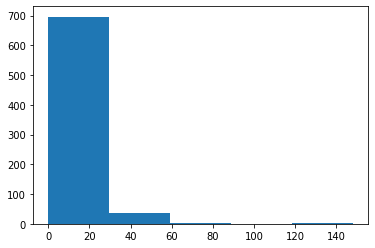

[  0.          49.33333333  98.66666667 148.        ]


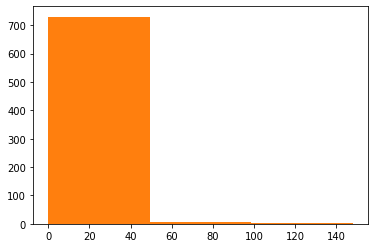

In [ ]:


import matplotlib.pyplot as plt
mpgs = df['EF_1']
plt.hist(mpgs, bins=5)
ef1_cut=plt.hist(mpgs, bins=5)[1]
plt.show()
import matplotlib.pyplot as plt
mpgs = df['Twitter Sentiments']
plt.hist(mpgs, bins=5)
plt.show()
twitter_cut=plt.hist(mpgs, bins=3)[1]
print(plt.hist(mpgs, bins=3)[1]
)




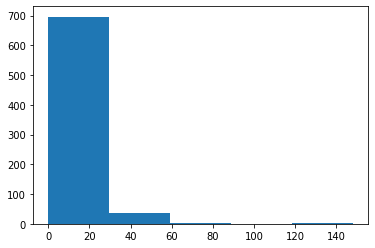

[  0.          49.33333333  98.66666667 148.        ]


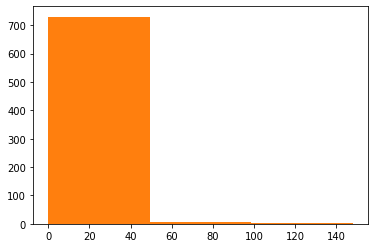

In [ ]:


import matplotlib.pyplot as plt
mpgs = df['Twitter Sentiments']
plt.hist(mpgs, bins=5)
plt.show()
twitter_cut=plt.hist(mpgs, bins=3)[1]
print(plt.hist(mpgs, bins=3)[1]
)



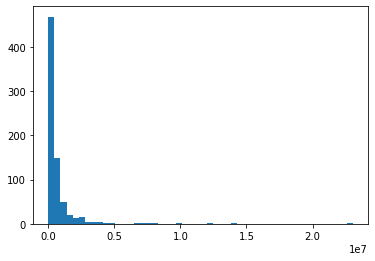

[1.66000e+04 7.68790e+06 1.53592e+07 2.30305e+07]


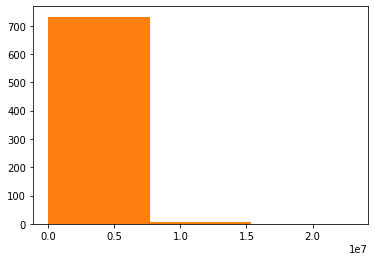

In [ ]:


import matplotlib.pyplot as plt
mpgs = df['Volume']
plt.hist(mpgs, bins=50)
plt.show()
twitter_cut=plt.hist(mpgs, bins=3)[1]
print(plt.hist(mpgs, bins=3)[1]
)



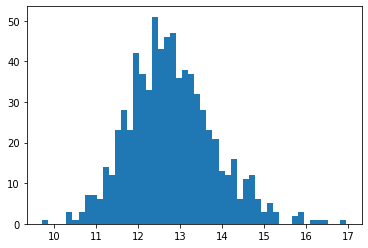

[ 9.71715797 12.12888198 14.54060598 16.95232998]


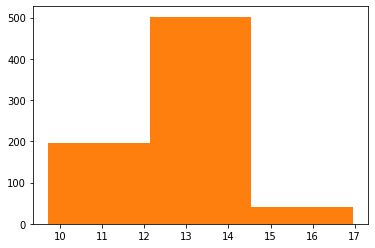

In [ ]:


import matplotlib.pyplot as plt
mpgs = np.log(df['Volume'])
plt.hist(mpgs, bins=50)
plt.show()
twitter_cut=plt.hist(mpgs, bins=3)[1]
print(plt.hist(mpgs, bins=3)[1]
)



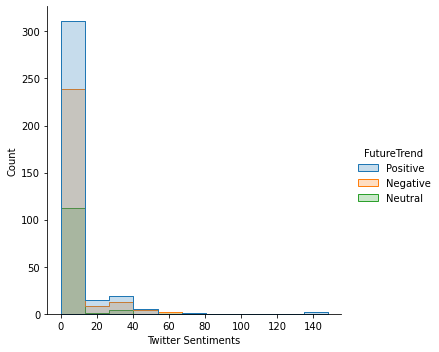

In [ ]:
import seaborn as sns
sns.displot(df, x="Twitter Sentiments", hue="FutureTrend",element="step")

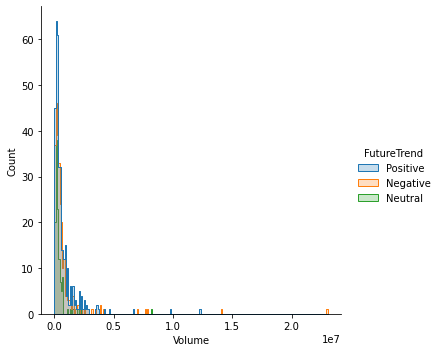

In [ ]:
import seaborn as sns
sns.displot(df, x="Volume", hue="FutureTrend",element="step",)

array([ 9.71715797, 12.12888198, 14.54060598, 16.95232998])

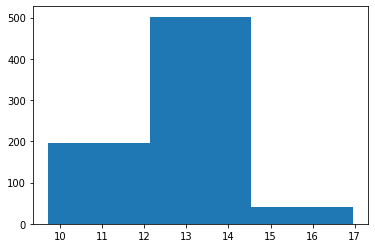

In [ ]:
plt.hist(mpgs, bins=3)[1]

In [ ]:
def make_bins(df):
   label_names = ["Ef_1_v_low","Ef_1_low","Ef_1_v_med","Ef1_high", "Ef1_very_high" ]
   cut_points =ef1_cut
   df["EF_1_val"] = pd.cut(df["EF_1"], cut_points, labels=label_names)
   dummies = pd.get_dummies(df["EF_1_val"],drop_first=True)
   df = pd.concat([df, dummies], axis=1)
   label_names = ["setinent_neutral","sentiment_good","sentiment_bad"]
   cut_points =twitter_cut
   df["sentiments"]=pd.cut(df['Twitter Sentiments'], cut_points, labels=label_names)
   dummies1 = pd.get_dummies(df["sentiments"],drop_first=True)
   df = pd.concat([df, dummies1], axis=1)
   df.drop(["EF_1_val","sentiments"],axis=1,inplace=True)
   return df
def calculate_ema(prices, days, smoothing=2):
      ema = [sum(prices[:days]) / days]
      for price in prices[days:]:
          ema.append((price * (smoothing / (1 + days))) + ema[-1] * (1 - (smoothing / (1 + days))))
      return ema

In [ ]:
target=df['FutureTrend']
df=df.drop("FutureTrend",axis =1)
target= target.replace(['Negative','Positive',  'Neutral'],[0,1,2])
df= df.replace(['Negative','Positive',  'Neutral'],[0,1,2])

appl_df =df.set_index('Date',inplace=True)
appl_df = make_bins(df)
appl_df.head(2)
appl_df=appl_df.drop(["Twitter Sentiments"],axis =1)
appl_df['diff']=appl_df['Close']-appl_df['Open']
appl_df['10day']=appl_df['Close'].rolling(10).mean()
appl_df['10day'].fillna(appl_df['10day'][9],inplace=True)
appl_df['Volume']=np.log(appl_df['Volume'])
ema = calculate_ema(appl_df['Close'], 10)
appl_df=appl_df[9:]
target=target[9:]
appl_df['ema']=ema
appl_df['signal']=appl_df['ema']>appl_df['Close']

del (appl_df['Open'])
del (appl_df['Close'])
del (appl_df['High'])
del (appl_df['EF_2'])

from imblearn.over_sampling import SMOTE
# pd.DataFrame(oe_df)
oversample = SMOTE()
appl_df, target = oversample.fit_resample(appl_df, target)


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
new_df=appl_df
print(new_df.head(2))

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)
numerical_columns = numerical_columns_selector(new_df)
categorical_columns = categorical_columns_selector(new_df)
print(categorical_columns)
preprocessor = ColumnTransformer([
  # ('one-hot-encoder', categorical_preprocessor, categorical_columns),
   ('standard-scaler', numerical_preprocessor, numerical_columns)
    ])
new_df=preprocessor.fit_transform(new_df)
X_train,X_test, y_train, y_test = train_test_split(new_df, target, test_size=0.2,random_state=42)

                        

    Low     Volume      EF_1  Oil FutureTrend  Gold FutureTrend  Trend  \
0  1.65  12.093464  0.499999                0                 1      0   
1  1.64  12.413087  0.363636                0                 0      2   

   Ef_1_low  Ef_1_v_med  Ef1_high  Ef1_very_high  sentiment_good  \
0         0           1         0              0               0   
1         1           0         0              0               0   

   sentiment_bad  diff  10day       ema  signal  
0              0 -0.02  1.689  1.689000    True  
1              0  0.00  1.681  1.687364    True  
[]


In [ ]:

clf = RandomForestClassifier(max_depth=3, random_state=5, warm_start=True, n_jobs=-1 )
ada = AdaBoostClassifier(base_estimator=clf, algorithm="SAMME.R", n_estimators=50, learning_rate = 0.3)
ada.fit(X_train,y_train)

AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=3, n_jobs=-1,
                                                         random_state=5,
                                                         warm_start=True),
                   learning_rate=0.3)

In [ ]:
print("Accuracy score (training): {0:.3f}".format(
        ada.score(
            X_train, 
            y_train)))
print("Accuracy score (validation): {0:.3f}".format(
        ada.score(
            X_test, 
            y_test)))

Accuracy score (training): 0.804
Accuracy score (validation): 0.476


In [ ]:
parameters = {
    'n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20],
    'learning_rate': [(0.97 + x / 100) for x in range(0, 8)],
    'algorithm': ['SAMME', 'SAMME.R']
}
clf = GridSearchCV(ab_clf, parameters, cv=5, verbose=VERBOSE, n_jobs=N_JOBS)
clf.fit(X_train, y_train)
plot_grid_search(clf)
table_grid_search(clf)

Hyper Parameter tuning 

In [ ]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

  
seed = 8
kfold = model_selection.KFold(n_splits = 5,
                       )
  

# no. of base classifier
num_trees = 500
for num_trees in [5,10,15]:
# bagging classifier
  model_3 = BaggingClassifier(base_estimator = ada,
                            n_estimators = num_trees,
                            random_state = seed)
  X_train,X_test, y_train, y_test = train_test_split(new_df, target, test_size=0.2, random_state=42)

  model_3.fit(X_train,y_train)
  print("Accuracy score (training): {0:.3f}".format(
        model_3.score(
            X_train, 
            y_train)))
  print("Accuracy score (validation): {0:.3f}".format(
        model_3.score(
            X_test, 
            y_test)))
  # results = model_selection.cross_val_score(model_3, X_train, y_train, cv = kfold)
  # print("accuracy :")
  # print("num_trees :",num_trees,results.mean())

Accuracy score (training): 0.766
Accuracy score (validation): 0.486


Hyper parameter tuning on Bagging + Ensemble classifier (took too much time)

In [ ]:
# param_grid = {
#     'base_estimator__max_depth' : [1, 2, 3, 4, 5],
#     'max_samples' : [0.05, 0.1, 0.2, 0.5],
#     'n_estimators' : [5,10,20,40,60],
#     'bootstrap' :[True,False]

# }


# #Fitting Bagging Classifier model with  hyper parameters
# # bagg = BaggingClassifier(bootstrap=True,n_estimators=200)
# # gridbag = GridSearchCV(bagg, param_grid=param_grid, cv = 3, verbose = 1)
# # bestbag = gridbag.fit(X_train, y_train)

# gridbag = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(),
#                                      n_estimators = 250, max_features = 0.5),
#                    param_grid)
# gridbag.fit(X_train, y_train)
# print("Accuracy score (training): {0:.3f}".format(
#         gridbag.score(
#             X_train, 
#             y_train)))
# print("Accuracy score (validation): {0:.3f}".format(
#         gridbag.score(
#             X_test, 
#             y_test)))


In [ ]:
# #Printing the best hyperparameters
# print('The best hyper parameters are:\n',gridbag.best_params_)



# #Checking different metrics for bagging model after tuning the hyperparameters
# print('Checking with the best hyper parameter on bagging model after tuning the hyperparameters:\n')

# bestbag=BaggingClassifier(bootstrap= False, max_samples=0.5, n_estimators= 40,max_features=0.6
#                           ,random_state=45
#                           )
# bestbag.fit(X_train,y_train)
# print("Accuracy score (training): {0:.3f}".format(
#         bestbag.score(
#             X_train, 
#             y_train)))
# print("Accuracy score (validation): {0:.3f}".format(
#         bestbag.score(
#             X_test, 
#             y_test)))
